In [1]:
import gc, os, random, pickle
import pandas as pd
import numpy as np
import scipy
from scipy import stats

# 导入模型和sklearn
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score,auc, log_loss
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tqdm import tqdm 
from imblearn.over_sampling import SMOTE
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)
    
'''seaborn and matplotlib'''
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

'''plotly'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

'''按markdown格式展现数据'''
init_notebook_mode(connected = True)
from IPython.display import Markdown

def bold(string):
    display(Markdown(string))


In [2]:
# 加载数据
train = pd.read_csv("../data/train.csv")
train_label = pd.read_csv("../data/train_label.csv")
test = pd.read_csv("../data/test.csv")
print(train.shape, train_label.shape, test.shape)



C:\Users\bai\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning:

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.



(14366, 178) (14366, 2) (9578, 178)


In [3]:
print(train_label['Label'].value_counts()) # 正负样本极度不均衡 需要采样

#采样前， 先对不相关的特征做剔除，填充空值

0    13425
1      941
Name: Label, dtype: int64


In [4]:
# 特征工程

train.dtypes

ID                   int64
企业类型               float64
经营期限至               object
登记机关               float64
企业状态               float64
邮政编码                object
投资总额               float64
注册资本               float64
核准日期                object
行业代码               float64
注销时间                object
经营期限自               object
成立日期                object
行业门类               float64
企业类别               float64
管辖机关               float64
经营范围                object
增值税                float64
企业所得税              float64
印花税                float64
教育费                float64
城建税                float64
递延收益_年初数           float64
长期负债合计_年初数         float64
长期借款_年初数           float64
长期应付款_年初数          float64
短期借款_年初数           float64
递延所得税负债_年初数        float64
非流动负债合计_年初数        float64
负债合计_年初数           float64
负债和所有者权益总计_年初数     float64
交易性金融负债_年初数        float64
流动负债合计_年初数         float64
其他非流动负债_年初数        float64
其他负债（或长期负债）_年初数    float64
其他流动负债_年初数         float64
其他应付款_年初数          float64
其

## 将特征可以分为两大类

```
第1大类：
ID                   int64     ==> 删除
行业代码               float64  ==> 删除
邮政编码                object  ==> 删除 没啥用

企业类型               float64  ==> 类别
登记机关               float64  ==> 类别
企业状态               float64  ==> 类别
行业门类               float64  ==> 类别
企业类别               float64  ==> 类别
管辖机关               float64  ==> 类别

经营期限自               object ==> 时间特征 ==> 时间类特征格式有问题，估计要转换，暂时不知道怎么用，先删除
经营期限至               object ==> 时间特征
核准日期                object  ==> 时间特征
成立日期                object  ==> 时间特征
注销时间                object  ==> 时间特征

经营范围                object  ==>  列表， 需要转为列表范围,

投资总额               float64  ==> 数值 极度稀疏，1.4w数据中约1.3w缺失
注册资本               float64  ==> 数值
增值税                 float64  ==> 数值
企业所得税             float64   ==> 数值
印花税                 float64   ==> 数值
教育费                 float64   ==> 数值
城建税                 float64   ==> 数值

时间特征 time_feature = ['经营期限自','经营期限至', '核准日期', '成立日期', '注销时间']
需要删除列 drop_feature = ['ID', '邮政编码', '行业代码', '经营范围']
类别特征   categoty_feature = ['企业类型', '登记机关', '企业状态', '行业门类','企业类别', '管辖机关']
数值型特征  ['投资总额', '注册资本', '增值税', '企业所得税', '印花税', '教育费', '城建税']  
需要构建的特征：==> baseline下看到的
'企业所得税比增值税'， 也可以类似构建 '企业所得税'和其他几个数值型特征之比


第2大类：所有包含年末 年初的数据-- 除开第1大类的其他大类
递延收益_年初数           float64
长期负债合计_年初数         float64
长期借款_年初数           float64
长期应付款_年初数          float64
短期借款_年初数           float64
递延所得税负债_年初数        float64
非流动负债合计_年初数        float64
负债合计_年初数           float64
负债和所有者权益总计_年初数     float64
交易性金融负债_年初数        float64
流动负债合计_年初数         float64
其他非流动负债_年初数        float64
其他负债（或长期负债）_年初数    float64
其他流动负债_年初数         float64
其他应付款_年初数          float64
其他应交款_年初数          float64
实收资本（股本）_年初数       float64
实收资本（或股本）净额_年初数    float64
所有者权益合计_年初数        float64
未分配利润_年初数          float64
小企业_应付利润_年初数       float64
应付福利费_年初数          float64
应付股利_年初数           float64
应付利息_年初数           float64
应付票据_年初数           float64
应付职工薪酬_年初数         float64
应付债券_年初数           float64
应付账款_年初数           float64
预计负债_年初数           float64
应交税费_年初数           float64
一年内到期的非流动负债_年初数    float64
预提费用_年初数           float64
预收款项_年初数           float64
盈余公积_年初数           float64
资本公积_年初数           float64
专项应付款_年初数          float64
递延收益_年末数           float64
长期负债合计_年末数         float64
长期借款_年末数           float64
长期应付款_年末数          float64
短期借款_年末数           float64
递延所得税负债_年末数        float64
非流动负债合计_年末数        float64
负债合计_年末数           float64
负债和所有者权益总计_年末数     float64
交易性金融负债_年末数        float64
流动负债合计_年末数         float64
其他非流动负债_年末数        float64
其他负债（或长期负债）_年末数    float64
其他流动负债_年末数         float64
其他应付款_年末数          float64
其他应交款_年末数          float64
实收资本（股本）_年末数       float64
实收资本（或股本）净额_年末数    float64
所有者权益合计_年末数        float64
未分配利润_年末数          float64
小企业_应付利润_年末数       float64
应付福利费_年末数          float64
应付股利_年末数           float64
应付利息_年末数           float64
应付票据_年末数           float64
应付职工薪酬_年末数         float64
应付债券_年末数           float64
应付账款_年末数           float64
预计负债_年末数           float64
应交税费_年末数           float64
一年内到期的非流动负债_年末数    float64
预提费用_年末数           float64
预收款项_年末数           float64
盈余公积_年末数           float64
资本公积_年末数           float64
专项应付款_年末数          float64
货币资金_年初数           float64
存货_年初数             float64
存货中的原材料_年初数        float64
存货中的周转材料_年初数       float64
长期待摊费用_年初数         float64
长期股权投资_年初数         float64
长期投资合计_年初数         float64
长期应收款_年初数          float64
持有至到期投资_年初数        float64
短期投资_年初数           float64
待摊费用_年初数           float64
递延所得税资产_年初数        float64
非流动资产合计_年初数        float64
工程物资_年初数           float64
固定资产合计_年初数         float64
固定资产净额_年初数         float64
固定资产净值_年初数         float64
固定资产清理_年初数         float64
固定资产原价_年初数         float64
交易性金融资产_年初数        float64
库存商品(产成品)_年初数      float64
开发支出_年初数           float64
可供出售金融资产_年初数       float64
流动资产合计_年初数         float64
其他非流动资产_年初数        float64
其他流动资产_年初数         float64
其他应收款_年初数          float64
生产性生物资产_年初数        float64
商誉_年初数             float64
投资性房地产_年初数         float64
无形资产_年初数           float64
无形资产及其他资产合计_年初数    float64
应收账款_年初数           float64
一年内到期的非流动资产_年初数    float64
油气资产_年初数           float64
应收补贴款_年初数          float64
应收股利_年初数           float64
应收利息_年初数           float64
应收票据_年初数           float64
预付款项_年初数           float64
资产总计_年初数           float64
在建工程_年初数           float64
货币资金_年末数           float64
存货_年末数             float64
存货中的原材料_年末数        float64
存货中的周转材料_年末数       float64
长期待摊费用_年末数         float64
长期股权投资_年末数         float64
长期投资合计_年末数         float64
长期应收款_年末数          float64
持有至到期投资_年末数        float64
短期投资_年末数           float64
待摊费用_年末数           float64
递延所得税资产_年末数        float64
非流动资产合计_年末数        float64
工程物资_年末数           float64
固定资产合计_年末数         float64
固定资产净额_年末数         float64
固定资产净值_年末数         float64
固定资产清理_年末数         float64
固定资产原价_年末数         float64
交易性金融资产_年末数        float64
库存商品(产成品)_年末数      float64
开发支出_年末数           float64
可供出售金融资产_年末数       float64
流动资产合计_年末数         float64
其他非流动资产_年末数        float64
其他流动资产_年末数         float64
其他应收款_年末数          float64
生产性生物资产_年末数        float64
商誉_年末数             float64
投资性房地产_年末数         float64
无形资产_年末数           float64
无形资产及其他资产合计_年末数    float64
应收账款_年末数           float64
一年内到期的非流动资产_年末数    float64
油气资产_年末数           float64
应收补贴款_年末数          float64
应收股利_年末数           float64
应收利息_年末数           float64
应收票据_年末数           float64
预付款项_年末数           float64
资产总计_年末数           float64
在建工程_年末数           float64
```

In [5]:
time_feature = ['经营期限自','经营期限至', '核准日期', '成立日期', '注销时间']
drop_feature = ['ID', '邮政编码', '行业代码', '经营范围']
categoty_feature = ['企业类型', '登记机关', '企业状态', '行业门类','企业类别', '管辖机关']
tax_feature= ['投资总额', '注册资本', '增值税', '企业所得税', '印花税', '教育费', '城建税']  # 税收类特征
#需要构建的特征：==> baseline下看到的
# '企业所得税比增值税'， 也可以类似构建 '企业所得税'和其他几个数值型特征之比


In [7]:
train['经营范围2'] =train["经营范围"].map(lambda x : len(x))
test['经营范围2'] =test["经营范围"].map(lambda x : len(x))


In [8]:
drop_feature += time_feature
drop_feature += ['经营范围']
print(drop_feature)

['ID', '邮政编码', '行业代码', '经营范围', '经营期限自', '经营期限至', '核准日期', '成立日期', '注销时间', '经营范围']


In [9]:
train.drop(columns=drop_feature, inplace=True)
test.drop(columns=drop_feature, inplace=True)
print(train.shape, test.shape)

(14366, 170) (9578, 170)


In [16]:
train['企业所得税与增值税之比'] = train['企业所得税']/ train['增值税']
test['企业所得税与增值税之比'] = test['企业所得税']/test['增值税']


In [10]:
display(train.head(2))

,企业类型,登记机关,企业状态,投资总额,注册资本,行业门类,企业类别,管辖机关,增值税,企业所得税,印花税,教育费,城建税,递延收益_年初数,长期负债合计_年初数,长期借款_年初数,长期应付款_年初数,短期借款_年初数,递延所得税负债_年初数,非流动负债合计_年初数,负债合计_年初数,负债和所有者权益总计_年初数,交易性金融负债_年初数,流动负债合计_年初数,其他非流动负债_年初数,其他负债（或长期负债）_年初数,其他流动负债_年初数,其他应付款_年初数,其他应交款_年初数,实收资本（股本）_年初数,实收资本（或股本）净额_年初数,所有者权益合计_年初数,未分配利润_年初数,小企业_应付利润_年初数,应付福利费_年初数,应付股利_年初数,应付利息_年初数,应付票据_年初数,应付职工薪酬_年初数,应付债券_年初数,应付账款_年初数,预计负债_年初数,应交税费_年初数,一年内到期的非流动负债_年初数,预提费用_年初数,预收款项_年初数,盈余公积_年初数,资本公积_年初数,专项应付款_年初数,递延收益_年末数,长期负债合计_年末数,长期借款_年末数,长期应付款_年末数,短期借款_年末数,递延所得税负债_年末数,非流动负债合计_年末数,负债合计_年末数,负债和所有者权益总计_年末数,交易性金融负债_年末数,流动负债合计_年末数,其他非流动负债_年末数,其他负债（或长期负债）_年末数,其他流动负债_年末数,其他应付款_年末数,其他应交款_年末数,实收资本（股本）_年末数,实收资本（或股本）净额_年末数,所有者权益合计_年末数,未分配利润_年末数,小企业_应付利润_年末数,应付福利费_年末数,应付股利_年末数,应付利息_年末数,应付票据_年末数,应付职工薪酬_年末数,应付债券_年末数,应付账款_年末数,预计负债_年末数,应交税费_年末数,一年内到期的非流动负债_年末数,预提费用_年末数,预收款项_年末数,盈余公积_年末数,资本公积_年末数,专项应付款_年末数,货币资金_年初数,存货_年初数,存货中的原材料_年初数,存货中的周转材料_年初数,长期待摊费用_年初数,长期股权投资_年初数,长期投资合计_年初数,长期应收款_年初数,持有至到期投资_年初数,短期投资_年初数,待摊费用_年初数,递延所得税资产_年初数,非流动资产合计_年初数,工程物资_年初数,固定资产合计_年初数,固定资产净额_年初数,固定资产净值_年初数,固定资产清理_年初数,固定资产原价_年初数,交易性金融资产_年初数,库存商品(产成品)_年初数,开发支出_年初数,可供出售金融资产_年初数,流动资产合计_年初数,其他非流动资产_年初数,其他流动资产_年初数,其他应收款_年初数,生产性生物资产_年初数,商誉_年初数,投资性房地产_年初数,无形资产_年初数,无形资产及其他资产合计_年初数,应收账款_年初数,一年内到期的非流动资产_年初数,油气资产_年初数,应收补贴款_年初数,应收股利_年初数,应收利息_年初数,应收票据_年初数,预付款项_年初数,资产总计_年初数,在建工程_年初数,货币资金_年末数,存货_年末数,存货中的原材料_年末数,存货中的周转材料_年末数,长期待摊费用_年末数,长期股权投资_年末数,长期投资合计_年末数,长期应收款_年末数,持有至到期投资_年末数,短期投资_年末数,待摊费用_年末数,递延所得税资产_年末数,非流动资产合计_年末数,工程物资_年末数,固定资产合计_年末数,固定资产净额_年末数,固定资产净值_年末数,固定资产清理_年末数,固定资产原价_年末数,交易性金融资产_年末数,库存商品(产成品)_年末数,开发支出_年末数,可供出售金融资产_年末数,流动资产合计_年末数,其他非流动资产_年末数,其他流动资产_年末数,其他应收款_年末数,生产性生物资产_年末数,商誉_年末数,投资性房地产_年末数,无形资产_年末数,无形资产及其他资产合计_年末数,应收账款_年末数,一年内到期的非流动资产_年末数,油气资产_年末数,应收补贴款_年末数,应收股利_年末数,应收利息_年末数,应收票据_年末数,预付款项_年末数,资产总计_年末数,在建工程_年末数,经营范围2
0,9.0,1.0,0.0,19.110000,19.110000,1.0,0.0,1.0,106.03965,0.331552,1.247218,3.181189,7.422776,0.0,0.0,25.110484,0.0,0.0,0.0,25.110484,797.386637,844.162546,0.0,772.276153,0.0,0.0,0.0,106.078436,0.0,50.220972,0.0,46.77591,-3.445063,0.0,0.0,0.0,0.0,125.552431,0.0,0.0,520.839979,0.0,19.805307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,585.013852,632.032182,0.0,585.013852,0.0,0.0,0.0,83.123866,0.0,50.220972,0.0,47.01833,-3.202643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,489.934244,0.0,11.955743,0.0,0.0,0.0,0.0,0.0,0.0,24.579246,462.290647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,135.081011,0.0,135.081011,0.0,0.0,0.0,368.329907,0.0,0.0,0.0,0.0,709.081535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,215.371727,0.0,0.0,0.0,0.0,0.0,2.647788,4.192126,844.162546,0.0,31.416284,229.147518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.128884,0.0,0.0,99.813781,0.0,99.813781,0.0,0.0,0.0,368.329907,0.0,0.0,0.0,0.0,532.218401,0.0,0.0,20.088389,0.0,0.0,0.0,0.0,0.0,142.310005,0.0,0.0,0.0,0.0,0.0,28.122902,1.004419,632.032182,0.0,244
1,11.0,5.0,0.0,29.154194,19.210446,0.0,2.0,3.0,39.17560,51.244655,0.014363,1.175269,2.742293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126


In [11]:
train['递延收益'] = train['递延收益_年末数'] - train['递延收益_年初数']
train['长期负债合计'] = train['长期负债合计_年末数'] - train['长期负债合计_年初数']
train['长期借款'] = train['长期借款_年末数'] - train['长期借款_年初数']
train['长期应付款'] = train['长期应付款_年末数'] - train['长期应付款_年初数']
train['短期借款'] = train['短期借款_年末数'] - train['短期借款_年初数']
train['递延所得税负债'] = train['递延所得税负债_年末数'] - train['递延所得税负债_年初数']
train['非流动负债合计'] = train['非流动负债合计_年末数'] - train['非流动负债合计_年初数']
train['负债合计'] = train['负债合计_年末数'] - train['负债合计_年初数']
train['负债和所有者权益总计'] = train['负债和所有者权益总计_年末数'] - train['负债和所有者权益总计_年初数']
train['交易性金融负债'] = train['交易性金融负债_年末数'] - train['交易性金融负债_年初数']
train['流动负债合计'] = train['流动负债合计_年末数'] - train['流动负债合计_年初数']
train['其他非流动负债'] = train['其他非流动负债_年末数'] - train['其他非流动负债_年初数']
train['其他负债（或长期负债）'] = train['其他负债（或长期负债）_年末数'] - train['其他负债（或长期负债）_年初数']
train['其他流动负债'] = train['其他流动负债_年末数'] - train['其他流动负债_年初数']
train['其他应付款'] = train['其他应付款_年末数'] - train['其他应付款_年初数']
train['其他应交款'] = train['其他应交款_年末数'] - train['其他应交款_年初数']
train['实收资本（股本）'] = train['实收资本（股本）_年末数'] - train['实收资本（股本）_年初数']
train['实收资本（或股本）净额'] = train['实收资本（或股本）净额_年末数'] - train['实收资本（或股本）净额_年初数']
train['所有者权益合计'] = train['所有者权益合计_年末数'] - train['所有者权益合计_年初数']
train['未分配利润'] = train['未分配利润_年末数'] - train['未分配利润_年初数']
train['小企业_应付利润'] = train['小企业_应付利润_年末数'] - train['小企业_应付利润_年初数']
train['应付福利费'] = train['应付福利费_年末数'] - train['应付福利费_年初数']
train['应付股利'] = train['应付股利_年末数'] - train['应付股利_年初数']
train['应付利息'] = train['应付利息_年末数'] - train['应付利息_年初数']
train['应付票据'] = train['应付票据_年末数'] - train['应付票据_年初数']
train['应付职工薪酬'] = train['应付职工薪酬_年末数'] - train['应付职工薪酬_年初数']
train['应付债券'] = train['应付债券_年末数'] - train['应付债券_年初数']
train['应付账款'] = train['应付账款_年末数'] - train['应付账款_年初数']
train['预计负债'] = train['预计负债_年末数'] - train['预计负债_年初数']
train['应交税费'] = train['应交税费_年末数'] - train['应交税费_年初数']
train['一年内到期的非流动负债'] = train['一年内到期的非流动负债_年末数'] - train['一年内到期的非流动负债_年初数']
train['预提费用'] = train['预提费用_年末数'] - train['预提费用_年初数']
train['预收款项'] = train['预收款项_年末数'] - train['预收款项_年初数']
train['盈余公积'] = train['盈余公积_年末数'] - train['盈余公积_年初数']
train['资本公积'] = train['资本公积_年末数'] - train['资本公积_年初数']
train['专项应付款'] = train['专项应付款_年末数'] - train['专项应付款_年初数']
train['货币资金'] = train['货币资金_年末数'] - train['货币资金_年初数']
train['存货'] = train['存货_年末数'] - train['存货_年初数']
train['存货中的原材料'] = train['存货中的原材料_年末数'] - train['存货中的原材料_年初数']
train['存货中的周转材料'] = train['存货中的周转材料_年末数'] - train['存货中的周转材料_年初数']
train['长期待摊费用'] = train['长期待摊费用_年末数'] - train['长期待摊费用_年初数']
train['长期股权投资'] = train['长期股权投资_年末数'] - train['长期股权投资_年初数']
train['长期投资合计'] = train['长期投资合计_年末数'] - train['长期投资合计_年初数']
train['长期应收款'] = train['长期应收款_年末数'] - train['长期应收款_年初数']
train['持有至到期投资'] = train['持有至到期投资_年末数'] - train['持有至到期投资_年初数']
train['短期投资'] = train['短期投资_年末数'] - train['短期投资_年初数']
train['待摊费用'] = train['待摊费用_年末数'] - train['待摊费用_年初数']
train['递延所得税资产'] = train['递延所得税资产_年末数'] - train['递延所得税资产_年初数']
train['非流动资产合计'] = train['非流动资产合计_年末数'] - train['非流动资产合计_年初数']
train['工程物资'] = train['工程物资_年末数'] - train['工程物资_年初数']
train['固定资产合计'] = train['固定资产合计_年末数'] - train['固定资产合计_年初数']
train['固定资产净额'] = train['固定资产净额_年末数'] - train['固定资产净额_年初数']
train['固定资产净值'] = train['固定资产净值_年末数'] - train['固定资产净值_年初数']
train['固定资产清理'] = train['固定资产清理_年末数'] - train['固定资产清理_年初数']
train['固定资产原价'] = train['固定资产原价_年末数'] - train['固定资产原价_年初数']
train['交易性金融资产'] = train['交易性金融资产_年末数'] - train['交易性金融资产_年初数']
train['库存商品(产成品)'] = train['库存商品(产成品)_年末数'] - train['库存商品(产成品)_年初数']
train['开发支出'] = train['开发支出_年末数'] - train['开发支出_年初数']
train['可供出售金融资产'] = train['可供出售金融资产_年末数'] - train['可供出售金融资产_年初数']
train['流动资产合计'] = train['流动资产合计_年末数'] - train['流动资产合计_年初数']
train['其他非流动资产'] = train['其他非流动资产_年末数'] - train['其他非流动资产_年初数']
train['其他流动资产'] = train['其他流动资产_年末数'] - train['其他流动资产_年初数']
train['其他应收款'] = train['其他应收款_年末数'] - train['其他应收款_年初数']
train['生产性生物资产'] = train['生产性生物资产_年末数'] - train['生产性生物资产_年初数']
train['商誉'] = train['商誉_年末数'] - train['商誉_年初数']
train['投资性房地产'] = train['投资性房地产_年末数'] - train['投资性房地产_年初数']
train['无形资产'] = train['无形资产_年末数'] - train['无形资产_年初数']
train['无形资产及其他资产合计'] = train['无形资产及其他资产合计_年末数'] - train['无形资产及其他资产合计_年初数']
train['应收账款'] = train['应收账款_年末数'] - train['应收账款_年初数']
train['一年内到期的非流动资产'] = train['一年内到期的非流动资产_年末数'] - train['一年内到期的非流动资产_年初数']
train['油气资产'] = train['油气资产_年末数'] - train['油气资产_年初数']
train['应收补贴款'] = train['应收补贴款_年末数'] - train['应收补贴款_年初数']
train['应收股利'] = train['应收股利_年末数'] - train['应收股利_年初数']
train['应收利息'] = train['应收利息_年末数'] - train['应收利息_年初数']
train['应收票据'] = train['应收票据_年末数'] - train['应收票据_年初数']
train['预付款项'] = train['预付款项_年末数'] - train['预付款项_年初数']
train['资产总计'] = train['资产总计_年末数'] - train['资产总计_年初数']
train['在建工程'] = train['在建工程_年末数'] - train['在建工程_年初数']


feature_class2  = ['递延收益', '长期负债合计', '长期借款', '长期应付款', '短期借款', '递延所得税负债', '非流动负债合计', '负债合计', '负债和所有者权益总计', '交易性金融负债', '流动负债合计', '其他非流动负债', '其他负债（或长期负债）', '其他流动负债', '其他应付款', '其他应交款', '实收资本（股本）', '实收资本（或股本）净额', '所有者权益合计', '未分配利润', '小企业_应付利润', '应付福利费', '应付股利', '应付利息', '应付票据', '应付职工薪酬', '应付债券', '应付账款', '预计负债', '应交税费', '一年内到期的非流动负债', '预提费用', '预收款项', '盈余公积', '资本公积', '专项应付款', '货币资金', '存货', '存货中的原材料', '存货中的周转材料', '长期待摊费用', '长期股权投资', '长期投资合计', '长期应收款', '持有至到期投资', '短期投资', '待摊费用', '递延所得税资产', '非流动资产合计', '工程物资', '固定资产合计', '固定资产净额', '固定资产净值', '固定资产清理', '固定资产原价', '交易性金融资产', '库存商品(产成品)', '开发支出', '可供出售金融资产', '流动资产合计', '其他非流动资产', '其他流动资产', '其他应收款', '生产性生物资产', '商誉', '投资性房地产', '无形资产', '无形资产及其他资产合计', '应收账款', '一年内到期的非流动资产', '油气资产', '应收补贴款', '应收股利', '应收利息', '应收票据', '预付款项', '资产总计', '在建工程']


In [12]:
test['递延收益'] = test['递延收益_年末数'] - test['递延收益_年初数']
test['长期负债合计'] = test['长期负债合计_年末数'] - test['长期负债合计_年初数']
test['长期借款'] = test['长期借款_年末数'] - test['长期借款_年初数']
test['长期应付款'] = test['长期应付款_年末数'] - test['长期应付款_年初数']
test['短期借款'] = test['短期借款_年末数'] - test['短期借款_年初数']
test['递延所得税负债'] = test['递延所得税负债_年末数'] - test['递延所得税负债_年初数']
test['非流动负债合计'] = test['非流动负债合计_年末数'] - test['非流动负债合计_年初数']
test['负债合计'] = test['负债合计_年末数'] - test['负债合计_年初数']
test['负债和所有者权益总计'] = test['负债和所有者权益总计_年末数'] - test['负债和所有者权益总计_年初数']
test['交易性金融负债'] = test['交易性金融负债_年末数'] - test['交易性金融负债_年初数']
test['流动负债合计'] = test['流动负债合计_年末数'] - test['流动负债合计_年初数']
test['其他非流动负债'] = test['其他非流动负债_年末数'] - test['其他非流动负债_年初数']
test['其他负债（或长期负债）'] = test['其他负债（或长期负债）_年末数'] - test['其他负债（或长期负债）_年初数']
test['其他流动负债'] = test['其他流动负债_年末数'] - test['其他流动负债_年初数']
test['其他应付款'] = test['其他应付款_年末数'] - test['其他应付款_年初数']
test['其他应交款'] = test['其他应交款_年末数'] - test['其他应交款_年初数']
test['实收资本（股本）'] = test['实收资本（股本）_年末数'] - test['实收资本（股本）_年初数']
test['实收资本（或股本）净额'] = test['实收资本（或股本）净额_年末数'] - test['实收资本（或股本）净额_年初数']
test['所有者权益合计'] = test['所有者权益合计_年末数'] - test['所有者权益合计_年初数']
test['未分配利润'] = test['未分配利润_年末数'] - test['未分配利润_年初数']
test['小企业_应付利润'] = test['小企业_应付利润_年末数'] - test['小企业_应付利润_年初数']
test['应付福利费'] = test['应付福利费_年末数'] - test['应付福利费_年初数']
test['应付股利'] = test['应付股利_年末数'] - test['应付股利_年初数']
test['应付利息'] = test['应付利息_年末数'] - test['应付利息_年初数']
test['应付票据'] = test['应付票据_年末数'] - test['应付票据_年初数']
test['应付职工薪酬'] = test['应付职工薪酬_年末数'] - test['应付职工薪酬_年初数']
test['应付债券'] = test['应付债券_年末数'] - test['应付债券_年初数']
test['应付账款'] = test['应付账款_年末数'] - test['应付账款_年初数']
test['预计负债'] = test['预计负债_年末数'] - test['预计负债_年初数']
test['应交税费'] = test['应交税费_年末数'] - test['应交税费_年初数']
test['一年内到期的非流动负债'] = test['一年内到期的非流动负债_年末数'] - test['一年内到期的非流动负债_年初数']
test['预提费用'] = test['预提费用_年末数'] - test['预提费用_年初数']
test['预收款项'] = test['预收款项_年末数'] - test['预收款项_年初数']
test['盈余公积'] = test['盈余公积_年末数'] - test['盈余公积_年初数']
test['资本公积'] = test['资本公积_年末数'] - test['资本公积_年初数']
test['专项应付款'] = test['专项应付款_年末数'] - test['专项应付款_年初数']
test['货币资金'] = test['货币资金_年末数'] - test['货币资金_年初数']
test['存货'] = test['存货_年末数'] - test['存货_年初数']
test['存货中的原材料'] = test['存货中的原材料_年末数'] - test['存货中的原材料_年初数']
test['存货中的周转材料'] = test['存货中的周转材料_年末数'] - test['存货中的周转材料_年初数']
test['长期待摊费用'] = test['长期待摊费用_年末数'] - test['长期待摊费用_年初数']
test['长期股权投资'] = test['长期股权投资_年末数'] - test['长期股权投资_年初数']
test['长期投资合计'] = test['长期投资合计_年末数'] - test['长期投资合计_年初数']
test['长期应收款'] = test['长期应收款_年末数'] - test['长期应收款_年初数']
test['持有至到期投资'] = test['持有至到期投资_年末数'] - test['持有至到期投资_年初数']
test['短期投资'] = test['短期投资_年末数'] - test['短期投资_年初数']
test['待摊费用'] = test['待摊费用_年末数'] - test['待摊费用_年初数']
test['递延所得税资产'] = test['递延所得税资产_年末数'] - test['递延所得税资产_年初数']
test['非流动资产合计'] = test['非流动资产合计_年末数'] - test['非流动资产合计_年初数']
test['工程物资'] = test['工程物资_年末数'] - test['工程物资_年初数']
test['固定资产合计'] = test['固定资产合计_年末数'] - test['固定资产合计_年初数']
test['固定资产净额'] = test['固定资产净额_年末数'] - test['固定资产净额_年初数']
test['固定资产净值'] = test['固定资产净值_年末数'] - test['固定资产净值_年初数']
test['固定资产清理'] = test['固定资产清理_年末数'] - test['固定资产清理_年初数']
test['固定资产原价'] = test['固定资产原价_年末数'] - test['固定资产原价_年初数']
test['交易性金融资产'] = test['交易性金融资产_年末数'] - test['交易性金融资产_年初数']
test['库存商品(产成品)'] = test['库存商品(产成品)_年末数'] - test['库存商品(产成品)_年初数']
test['开发支出'] = test['开发支出_年末数'] - test['开发支出_年初数']
test['可供出售金融资产'] = test['可供出售金融资产_年末数'] - test['可供出售金融资产_年初数']
test['流动资产合计'] = test['流动资产合计_年末数'] - test['流动资产合计_年初数']
test['其他非流动资产'] = test['其他非流动资产_年末数'] - test['其他非流动资产_年初数']
test['其他流动资产'] = test['其他流动资产_年末数'] - test['其他流动资产_年初数']
test['其他应收款'] = test['其他应收款_年末数'] - test['其他应收款_年初数']
test['生产性生物资产'] = test['生产性生物资产_年末数'] - test['生产性生物资产_年初数']
test['商誉'] = test['商誉_年末数'] - test['商誉_年初数']
test['投资性房地产'] = test['投资性房地产_年末数'] - test['投资性房地产_年初数']
test['无形资产'] = test['无形资产_年末数'] - test['无形资产_年初数']
test['无形资产及其他资产合计'] = test['无形资产及其他资产合计_年末数'] - test['无形资产及其他资产合计_年初数']
test['应收账款'] = test['应收账款_年末数'] - test['应收账款_年初数']
test['一年内到期的非流动资产'] = test['一年内到期的非流动资产_年末数'] - test['一年内到期的非流动资产_年初数']
test['油气资产'] = test['油气资产_年末数'] - test['油气资产_年初数']
test['应收补贴款'] = test['应收补贴款_年末数'] - test['应收补贴款_年初数']
test['应收股利'] = test['应收股利_年末数'] - test['应收股利_年初数']
test['应收利息'] = test['应收利息_年末数'] - test['应收利息_年初数']
test['应收票据'] = test['应收票据_年末数'] - test['应收票据_年初数']
test['预付款项'] = test['预付款项_年末数'] - test['预付款项_年初数']
test['资产总计'] = test['资产总计_年末数'] - test['资产总计_年初数']
test['在建工程'] = test['在建工程_年末数'] - test['在建工程_年初数']

In [17]:
train.dtypes

企业类型               float64
登记机关               float64
企业状态               float64
投资总额               float64
注册资本               float64
行业门类               float64
企业类别               float64
管辖机关               float64
增值税                float64
企业所得税              float64
印花税                float64
教育费                float64
城建税                float64
递延收益_年初数           float64
长期负债合计_年初数         float64
长期借款_年初数           float64
长期应付款_年初数          float64
短期借款_年初数           float64
递延所得税负债_年初数        float64
非流动负债合计_年初数        float64
负债合计_年初数           float64
负债和所有者权益总计_年初数     float64
交易性金融负债_年初数        float64
流动负债合计_年初数         float64
其他非流动负债_年初数        float64
其他负债（或长期负债）_年初数    float64
其他流动负债_年初数         float64
其他应付款_年初数          float64
其他应交款_年初数          float64
实收资本（股本）_年初数       float64
实收资本（或股本）净额_年初数    float64
所有者权益合计_年初数        float64
未分配利润_年初数          float64
小企业_应付利润_年初数       float64
应付福利费_年初数          float64
应付股利_年初数           float64
应付利息_年初数           float64
应

In [19]:
train.columns[np.where(train.isnull().sum()/train.shape[0] < 0.6)[0]]

Index(['企业类型', '登记机关', '企业状态', '注册资本', '行业门类', '企业类别', '管辖机关', '增值税', '企业所得税',
       '印花税',
       ...
       '一年内到期的非流动资产', '油气资产', '应收补贴款', '应收股利', '应收利息', '应收票据', '预付款项', '资产总计',
       '在建工程', '企业所得税与增值税之比'],
      dtype='object', length=248)

In [20]:
train.columns[np.where(train.isnull().sum()/train.shape[0] < 0.6)[0]].values

array(['企业类型', '登记机关', '企业状态', '注册资本', '行业门类', '企业类别', '管辖机关', '增值税',
       '企业所得税', '印花税', '教育费', '城建税', '递延收益_年初数', '长期负债合计_年初数', '长期借款_年初数',
       '长期应付款_年初数', '短期借款_年初数', '递延所得税负债_年初数', '非流动负债合计_年初数', '负债合计_年初数',
       '负债和所有者权益总计_年初数', '交易性金融负债_年初数', '流动负债合计_年初数', '其他非流动负债_年初数',
       '其他负债（或长期负债）_年初数', '其他流动负债_年初数', '其他应付款_年初数', '其他应交款_年初数',
       '实收资本（股本）_年初数', '实收资本（或股本）净额_年初数', '所有者权益合计_年初数', '未分配利润_年初数',
       '小企业_应付利润_年初数', '应付福利费_年初数', '应付股利_年初数', '应付利息_年初数', '应付票据_年初数',
       '应付职工薪酬_年初数', '应付债券_年初数', '应付账款_年初数', '预计负债_年初数', '应交税费_年初数',
       '一年内到期的非流动负债_年初数', '预提费用_年初数', '预收款项_年初数', '盈余公积_年初数', '资本公积_年初数',
       '专项应付款_年初数', '递延收益_年末数', '长期负债合计_年末数', '长期借款_年末数', '长期应付款_年末数',
       '短期借款_年末数', '递延所得税负债_年末数', '非流动负债合计_年末数', '负债合计_年末数',
       '负债和所有者权益总计_年末数', '交易性金融负债_年末数', '流动负债合计_年末数', '其他非流动负债_年末数',
       '其他负债（或长期负债）_年末数', '其他流动负债_年末数', '其他应付款_年末数', '其他应交款_年末数',
       '实收资本（股本）_年末数', '实收资本（或股本）净额_年末数', '所有者权益合计_年末数', '未分配利润_年末数',
       '小企业_应付利润_年末数', '

In [21]:
columns=['企业类型', '登记机关', '企业状态', '注册资本', '行业门类', '企业类别', '管辖机关', '增值税',
       '企业所得税', '印花税', '教育费', '城建税', '递延收益_年初数', '长期负债合计_年初数', '长期借款_年初数',
       '长期应付款_年初数', '短期借款_年初数', '递延所得税负债_年初数', '非流动负债合计_年初数', '负债合计_年初数',
       '负债和所有者权益总计_年初数', '交易性金融负债_年初数', '流动负债合计_年初数', '其他非流动负债_年初数',
       '其他负债（或长期负债）_年初数', '其他流动负债_年初数', '其他应付款_年初数', '其他应交款_年初数',
       '实收资本（股本）_年初数', '实收资本（或股本）净额_年初数', '所有者权益合计_年初数', '未分配利润_年初数',
       '小企业_应付利润_年初数', '应付福利费_年初数', '应付股利_年初数', '应付利息_年初数', '应付票据_年初数',
       '应付职工薪酬_年初数', '应付债券_年初数', '应付账款_年初数', '预计负债_年初数', '应交税费_年初数',
       '一年内到期的非流动负债_年初数', '预提费用_年初数', '预收款项_年初数', '盈余公积_年初数', '资本公积_年初数',
       '专项应付款_年初数', '递延收益_年末数', '长期负债合计_年末数', '长期借款_年末数', '长期应付款_年末数',
       '短期借款_年末数', '递延所得税负债_年末数', '非流动负债合计_年末数', '负债合计_年末数',
       '负债和所有者权益总计_年末数', '交易性金融负债_年末数', '流动负债合计_年末数', '其他非流动负债_年末数',
       '其他负债（或长期负债）_年末数', '其他流动负债_年末数', '其他应付款_年末数', '其他应交款_年末数',
       '实收资本（股本）_年末数', '实收资本（或股本）净额_年末数', '所有者权益合计_年末数', '未分配利润_年末数',
       '小企业_应付利润_年末数', '应付福利费_年末数', '应付股利_年末数', '应付利息_年末数', '应付票据_年末数',
       '应付职工薪酬_年末数', '应付债券_年末数', '应付账款_年末数', '预计负债_年末数', '应交税费_年末数',
       '一年内到期的非流动负债_年末数', '预提费用_年末数', '预收款项_年末数', '盈余公积_年末数', '资本公积_年末数',
       '专项应付款_年末数', '货币资金_年初数', '存货_年初数', '存货中的原材料_年初数', '存货中的周转材料_年初数',
       '长期待摊费用_年初数', '长期股权投资_年初数', '长期投资合计_年初数', '长期应收款_年初数',
       '持有至到期投资_年初数', '短期投资_年初数', '待摊费用_年初数', '递延所得税资产_年初数',
       '非流动资产合计_年初数', '工程物资_年初数', '固定资产合计_年初数', '固定资产净额_年初数',
       '固定资产净值_年初数', '固定资产清理_年初数', '固定资产原价_年初数', '交易性金融资产_年初数',
       '库存商品(产成品)_年初数', '开发支出_年初数', '可供出售金融资产_年初数', '流动资产合计_年初数',
       '其他非流动资产_年初数', '其他流动资产_年初数', '其他应收款_年初数', '生产性生物资产_年初数', '商誉_年初数',
       '投资性房地产_年初数', '无形资产_年初数', '无形资产及其他资产合计_年初数', '应收账款_年初数',
       '一年内到期的非流动资产_年初数', '油气资产_年初数', '应收补贴款_年初数', '应收股利_年初数', '应收利息_年初数',
       '应收票据_年初数', '预付款项_年初数', '资产总计_年初数', '在建工程_年初数', '货币资金_年末数',
       '存货_年末数', '存货中的原材料_年末数', '存货中的周转材料_年末数', '长期待摊费用_年末数',
       '长期股权投资_年末数', '长期投资合计_年末数', '长期应收款_年末数', '持有至到期投资_年末数', '短期投资_年末数',
       '待摊费用_年末数', '递延所得税资产_年末数', '非流动资产合计_年末数', '工程物资_年末数', '固定资产合计_年末数',
       '固定资产净额_年末数', '固定资产净值_年末数', '固定资产清理_年末数', '固定资产原价_年末数',
       '交易性金融资产_年末数', '库存商品(产成品)_年末数', '开发支出_年末数', '可供出售金融资产_年末数',
       '流动资产合计_年末数', '其他非流动资产_年末数', '其他流动资产_年末数', '其他应收款_年末数',
       '生产性生物资产_年末数', '商誉_年末数', '投资性房地产_年末数', '无形资产_年末数',
       '无形资产及其他资产合计_年末数', '应收账款_年末数', '一年内到期的非流动资产_年末数', '油气资产_年末数',
       '应收补贴款_年末数', '应收股利_年末数', '应收利息_年末数', '应收票据_年末数', '预付款项_年末数',
       '资产总计_年末数', '在建工程_年末数', '经营范围2', '递延收益', '长期负债合计', '长期借款', '长期应付款',
       '短期借款', '递延所得税负债', '非流动负债合计', '负债合计', '负债和所有者权益总计', '交易性金融负债',
       '流动负债合计', '其他非流动负债', '其他负债（或长期负债）', '其他流动负债', '其他应付款', '其他应交款',
       '实收资本（股本）', '实收资本（或股本）净额', '所有者权益合计', '未分配利润', '小企业_应付利润', '应付福利费',
       '应付股利', '应付利息', '应付票据', '应付职工薪酬', '应付债券', '应付账款', '预计负债', '应交税费',
       '一年内到期的非流动负债', '预提费用', '预收款项', '盈余公积', '资本公积', '专项应付款', '货币资金',
       '存货', '存货中的原材料', '存货中的周转材料', '长期待摊费用', '长期股权投资', '长期投资合计', '长期应收款',
       '持有至到期投资', '短期投资', '待摊费用', '递延所得税资产', '非流动资产合计', '工程物资', '固定资产合计',
       '固定资产净额', '固定资产净值', '固定资产清理', '固定资产原价', '交易性金融资产', '库存商品(产成品)',
       '开发支出', '可供出售金融资产', '流动资产合计', '其他非流动资产', '其他流动资产', '其他应收款',
       '生产性生物资产', '商誉', '投资性房地产', '无形资产', '无形资产及其他资产合计', '应收账款',
       '一年内到期的非流动资产', '油气资产', '应收补贴款', '应收股利', '应收利息', '应收票据', '预付款项',
       '资产总计', '在建工程', '企业所得税与增值税之比']

# 训练1

In [35]:
feature_name = columns #0.924763 
#特征选择  使用第1步分
# feature_name  =  ['企业类型', '登记机关', '企业状态', '注册资本', '行业门类', '企业类别', '管辖机关', '增值税', '企业所得税', '印花税', '教育费', '城建税', '递延收益_年初数', '长期借款_年初数', '长期应付款_年初数', '短期借款_年初数', '递延所得税负债_年初数', '非流动负债合计_年初数', '负债合计_年初数', '负债和所有者权益总计_年初数', '交易性金融负债_年初数', '流动负债合计_年初数', '其他非流动负债_年初数', '其他流动负债_年初数', '其他应付款_年初数', '实收资本（股本）_年初数', '实收资本（或股本）净额_年初数', '所有者权益合计_年初数', '未分配利润_年初数', '应付票据_年初数', '应付职工薪酬_年初数', '应付债券_年初数', '应付账款_年初数', '预计负债_年初数', '应交税费_年初数', '一年内到期的非流动负债_年初数', '预收款项_年初数', '盈余公积_年初数', '资本公积_年初数', '长期借款_年末数', '长期应付款_年末数', '递延所得税负债_年末数', '非流动负债合计_年末数', '负债合计_年末数', '负债和所有者权益总计_年末数', '流动负债合计_年末数', '其他非流动负债_年末数', '其他流动负债_年末数', '其他应付款_年末数', '实收资本（股本）_年末数', '小企业_应付利润_年末数', '应付股利_年末数', '应付票据_年末数', '应付职工薪酬_年末数', '应付债券_年末数', '应付账款_年末数', '预计负债_年末数', '应交税费_年末数', '一年内到期的非流动负债_年末数', '预收款项_年末数', '盈余公积_年末数', '资本公积_年末数', '专项应付款_年末数', '货币资金_年初数', '存货_年初数', '存货中的原材料_年初数', '长期待摊费用_年初数', '长期应收款_年初数', '短期投资_年初数', '待摊费用_年初数', '工程物资_年初数', '固定资产合计_年初数', '固定资产净值_年初数', '固定资产原价_年初数', '交易性金融资产_年初数', '库存商品(产成品)_年初数', '开发支出_年初数', '可供出售金融资产_年初数', '流动资产合计_年初数', '其他流动资产_年初数', '其他应收款_年初数', '生产性生物资产_年初数', '商誉_年初数', '无形资产_年初数', '应收账款_年初数', '应收股利_年初数', '应收票据_年初数', '预付款项_年初数', '资产总计_年初数', '货币资金_年末数', '存货_年末数', '存货中的原材料_年末数', '存货中的周转材料_年末数', '长期待摊费用_年末数', '长期股权投资_年末数', '长期应收款_年末数', '持有至到期投资_年末数', '递延所得税资产_年末数', '非流动资产合计_年末数', '工程物资_年末数', '固定资产合计_年末数', '固定资产清理_年末数', '固定资产原价_年末数', '交易性金融资产_年末数', '库存商品(产成品)_年末数', '开发支出_年末数', '可供出售金融资产_年末数', '流动资产合计_年末数', '其他非流动资产_年末数', '其他应收款_年末数', '生产性生物资产_年末数', '投资性房地产_年末数', '无形资产_年末数', '油气资产_年末数', '应收股利_年末数', '应收利息_年末数', '应收票据_年末数', '预付款项_年末数', '资产总计_年末数', '经营范围2', '递延收益', '长期负债合计', '长期应付款', '递延所得税负债', '负债合计', '交易性金融负债', '流动负债合计', '其他非流动负债', '其他流动负债', '其他应付款', '所有者权益合计', '未分配利润', '应付福利费', '应付股利', '应付职工薪酬', '应付账款', '预计负债', '应交税费', '一年内到期的非流动负债', '盈余公积', '资本公积', '货币资金', '存货', '存货中的原材料', '存货中的周转材料', '长期待摊费用', '持有至到期投资', '短期投资', '递延所得税资产', '非流动资产合计', '工程物资', '固定资产合计', '固定资产清理', '开发支出', '流动资产合计', '其他非流动资产', '其他流动资产', '其他应收款', '生产性生物资产', '无形资产', '应收账款', '一年内到期的非流动资产', '应收股利', '预付款项', '在建工程', '企业所得税与增值税之比']



fi = []
cv_score = []
test_pred = np.zeros((test.shape[0],))
skf = StratifiedKFold(n_splits=5, random_state=2019, shuffle=True)

for index, (train_index, test_index) in enumerate(skf.split(train, train_label['Label'])):
    print(index)
    train_x, test_x, train_y, test_y = train.iloc[train_index],train.iloc[test_index], train_label['Label'].iloc[train_index], train_label['Label'].iloc[test_index]
    cat_model = CatBoostRegressor(iterations=300,
                              depth=5,
                              learning_rate=0.1, 
                              loss_function='RMSE', 
                              verbose=20, 
#                               early_stopping_rounds=20
                             )
    cat_model.fit(train_x[feature_name], train_y, 
             eval_set=(test_x[feature_name], test_y))
    y_val = cat_model.predict(test_x[feature_name])
    print("roc_auc:", roc_auc_score(test_y, y_val))
    cv_score.append(roc_auc_score(test_y,y_val))
    print("cv_score:", cv_score[index])
    test_pred += cat_model.predict(test[feature_name]) / 5
print(cv_score)
test_pred = [0.0 if r < 0  else r for r in test_pred]
test_pred = [1.0 if r > 1.0  else r for r in test_pred]
submission = pd.read_csv('../data/submission.csv')
submission['Label'] = test_pred
submission.to_csv('../result/catb_dan_1207.csv',index=False)


0
0:	learn: 0.2419834	test: 0.2427520	best: 0.2427520 (0)	total: 33.2ms	remaining: 9.91s
20:	learn: 0.2125445	test: 0.2141120	best: 0.2141120 (20)	total: 269ms	remaining: 3.58s
40:	learn: 0.2103833	test: 0.2128381	best: 0.2128381 (40)	total: 483ms	remaining: 3.05s
60:	learn: 0.2098505	test: 0.2128547	best: 0.2128192 (47)	total: 726ms	remaining: 2.84s
80:	learn: 0.2086313	test: 0.2129022	best: 0.2128192 (47)	total: 968ms	remaining: 2.62s
100:	learn: 0.2072903	test: 0.2128567	best: 0.2127863 (88)	total: 1.21s	remaining: 2.39s
120:	learn: 0.2056607	test: 0.2129559	best: 0.2127863 (88)	total: 1.43s	remaining: 2.12s
140:	learn: 0.2038937	test: 0.2128905	best: 0.2127863 (88)	total: 1.65s	remaining: 1.86s
160:	learn: 0.2025060	test: 0.2126742	best: 0.2125823 (156)	total: 1.89s	remaining: 1.63s
180:	learn: 0.2008146	test: 0.2127423	best: 0.2124859 (171)	total: 2.14s	remaining: 1.41s
200:	learn: 0.1993856	test: 0.2131141	best: 0.2124859 (171)	total: 2.38s	remaining: 1.17s
220:	learn: 0.1980770	

In [ ]:
# 训练模型

**catboost特征重要性**

[2.73705520e-01 1.52441758e-01 4.43300155e-01 2.87082943e-01
 1.34297437e+00 4.27868697e-01 6.96971145e-01 1.29658575e+01
 2.84353547e+01 2.80252337e+00 6.80487003e+00 2.84497726e+01
 0.00000000e+00 0.00000000e+00 5.01696623e-03 3.73517264e-02
 7.57729041e-03 4.01580276e-04 3.84101232e-02 1.09326881e-02
 1.09955904e-02 9.90436196e-01 6.38678372e-03 0.00000000e+00
 0.00000000e+00 2.44411641e-02 1.80470931e-02 0.00000000e+00
 6.67857851e-02 2.34908374e-01 7.33282856e-02 8.63330411e-02
 3.57860248e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.26699277e-02 1.94397619e-02 1.19328073e-02 1.96986042e-02
 4.84037395e-03 2.59867367e-02 1.81824388e-05 0.00000000e+00
 1.01315265e-02 1.50106054e-03 2.42303886e-04 0.00000000e+00
 1.15606476e-01 0.00000000e+00 0.00000000e+00 2.76116118e-02
 4.39873803e-03 0.00000000e+00 1.14915252e-01 1.83391039e-02
 6.99413523e-02 3.82659446e-03 7.18746778e-02 2.69259879e-05
 4.46757609e-02 5.76646955e-02 1.37464933e-01 0.00000000e+00
 2.70229755e-02 0.000000

 catboost 重要性 > 0 特征类别： 168 ['城建税', '企业所得税', '增值税', '教育费', '企业所得税与增值税之比', '经营范围2', '印花税', '行业门类', '油气资产_年末数', '交易性金融负债_年初数', '生产性生物资产_年初数', '库存商品(产成品)_年初数', '管辖机关', '企业状态', '企业类别', '货币资金_年初数', '注册资本', '企业类型', '其他应收款_年初数', '实收资本（或股本）净额_年初数', '应收票据_年末数', '持有至到期投资', '非流动资产合计', '长期应付款', '登记机关', '流动资产合计_年末数', '工程物资_年初数', '货币资金_年末数', '其他应付款_年末数', '预付款项_年初数', '递延收益_年末数', '非流动负债合计_年末数', '无形资产', '其他应收款_年末数', '非流动负债合计', '交易性金融负债', '未分配利润_年初数', '固定资产合计_年初数', '长期负债合计', '无形资产_年末数', '所有者权益合计_年初数', '流动负债合计_年末数', '负债和所有者权益总计_年末数', '应收账款', '非流动资产合计_年初数', '实收资本（股本）_年初数', '应付票据_年初数', '应付职工薪酬', '其他流动负债_年末数', '应付股利', '资产总计_年初数', '预计负债', '其他负债（或长期负债）_年末数', '资本公积_年末数', '固定资产原价_年初数', '非流动负债合计_年初数', '长期应付款_年初数', '固定资产合计', '应收股利_年初数', '可供出售金融资产_年末数', '资产总计_年末数', '其他应收款', '长期应付款_年末数', '固定资产合计_年末数', '应收账款_年初数', '实收资本（股本）_年末数', '应交税费_年初数', '生产性生物资产_年末数', '短期借款', '其他流动负债_年初数', '应收股利_年末数', '固定资产原价', '无形资产_年初数', '未分配利润', '应付票据_年末数', '应付账款_年初数', '应付账款_年末数', '应付职工薪酬_年初数', '负债合计_年末数', '其他应付款_年初数', '可供出售金融资产_年初数', '长期待摊费

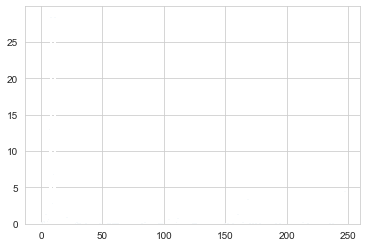

In [61]:
feature_name = columns
from matplotlib import pyplot
bold("**catboost特征重要性**")
print(cat_model.feature_importances_)
pyplot.bar(range(len(cat_model.feature_importances_)), cat_model.feature_importances_)
feature_important = dict(zip(feature_name, cat_model.feature_importances_))
feature_important=sorted(feature_important.items(), key=lambda x: x[1], reverse=True)
print(feature_important)


feature_import_usefull = [key for (key, value) in feature_important if value >0.0]

print("\n\n catboost 重要性 > 0 特征类别：", len(feature_import_usefull),  feature_import_usefull)


In [40]:
## xgboost 单模型
feature_name = columns

object_col = ['企业类型', '登记机关','企业状态', '行业门类', '企业类别', '管辖机关']
for i in tqdm(object_col):
    lbl = LabelEncoder()
    train[i] = lbl.fit_transform(train[i].astype(str))

fi = []
cv_score = []
test_pred = np.zeros((test.shape[0],))
skf = StratifiedKFold(n_splits=5, random_state=2019, shuffle=True)


for index, (train_index, test_index) in enumerate(skf.split(train, train_label['Label'])):
    print(index)
    train_x, test_x, train_y, test_y = train.iloc[train_index],train.iloc[test_index], train_label['Label'].iloc[train_index], train_label['Label'].iloc[test_index]
    xgb_model = XGBRegressor(learning_rate=0.15,
                              n_estimators=400,
                              max_depth=5,
                              gamma=0,
                              verbosity=1,
                              subsample=0.8,
                            #   min_child_weight=1, 
                              objective='binary:logistic')
    eval_set = [(train_x[feature_name], train_y), (test_x[feature_name], test_y)]
    xgb_model.fit(train_x[feature_name], train_y, 
#         early_stopping_rounds = 20,
        eval_metric=["error", "logloss",'auc'], 
        eval_set=eval_set, verbose=20)
    
   
    y_val = xgb_model.predict(test_x[feature_name])
    print("roc_auc:", roc_auc_score(test_y, y_val))
    cv_score.append(roc_auc_score(test_y, y_val))
    print("cv_score:", cv_score[index])
    test_pred += xgb_model.predict(test[feature_name]) / 5
print(cv_score)
test_pred = [0.0 if r < 0  else r for r in test_pred]
test_pred = [1.0 if r > 1.0  else r for r in test_pred]
submission = pd.read_csv('../data/submission.csv')
submission['Label'] = test_pred
submission.to_csv('../result/xgb_dan_1207.csv',index=False)

100%|██████████| 6/6 [00:00<00:00, 72.82it/s]


0


C:\Users\bai\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	validation_0-error:0.06709	validation_0-logloss:0.578699	validation_0-auc:0.912835	validation_1-error:0.073417	validation_1-logloss:0.579754	validation_1-auc:0.889869
[20]	validation_0-error:0.06213	validation_0-logloss:0.139121	validation_0-auc:0.948632	validation_1-error:0.066458	validation_1-logloss:0.156226	validation_1-auc:0.916205
[40]	validation_0-error:0.059433	validation_0-logloss:0.117427	validation_0-auc:0.964382	validation_1-error:0.066806	validation_1-logloss:0.144692	validation_1-auc:0.927772
[60]	validation_0-error:0.053603	validation_0-logloss:0.108522	validation_0-auc:0.97388	validation_1-error:0.065762	validation_1-logloss:0.144431	validation_1-auc:0.926637
[80]	validation_0-error:0.044988	validation_0-logloss:0.098821	validation_0-auc:0.980576	validation_1-error:0.067502	validation_1-logloss:0.14815	validation_1-auc:0.921607
[100]	validation_0-error:0.039767	validation_0-logloss:0.091026	validation_0-auc:0.985222	validation_1-error:0.072721	validation_1-logloss:0

C:\Users\bai\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	validation_0-error:0.064648	validation_0-logloss:0.578578	validation_0-auc:0.914702	validation_1-error:0.066829	validation_1-logloss:0.579441	validation_1-auc:0.898601
[20]	validation_0-error:0.062386	validation_0-logloss:0.13906	validation_0-auc:0.952095	validation_1-error:0.065785	validation_1-logloss:0.153927	validation_1-auc:0.91638
[40]	validation_0-error:0.060733	validation_0-logloss:0.119147	validation_0-auc:0.962604	validation_1-error:0.066829	validation_1-logloss:0.14378	validation_1-auc:0.916673
[60]	validation_0-error:0.053859	validation_0-logloss:0.108449	validation_0-auc:0.972857	validation_1-error:0.066133	validation_1-logloss:0.145094	validation_1-auc:0.915197
[80]	validation_0-error:0.044114	validation_0-logloss:0.098671	validation_0-auc:0.980405	validation_1-error:0.068221	validation_1-logloss:0.146561	validation_1-auc:0.91634
[100]	validation_0-error:0.038719	validation_0-logloss:0.090615	validation_0-auc:0.984956	validation_1-error:0.071354	validation_1-logloss:0

C:\Users\bai\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	validation_0-error:0.064648	validation_0-logloss:0.57839	validation_0-auc:0.914027	validation_1-error:0.067177	validation_1-logloss:0.580216	validation_1-auc:0.902805
[20]	validation_0-error:0.061951	validation_0-logloss:0.138129	validation_0-auc:0.95169	validation_1-error:0.066481	validation_1-logloss:0.155157	validation_1-auc:0.91392
[40]	validation_0-error:0.058557	validation_0-logloss:0.117253	validation_0-auc:0.963786	validation_1-error:0.067525	validation_1-logloss:0.145823	validation_1-auc:0.910002
[60]	validation_0-error:0.052554	validation_0-logloss:0.107798	validation_0-auc:0.972009	validation_1-error:0.071702	validation_1-logloss:0.148174	validation_1-auc:0.910201
[80]	validation_0-error:0.043418	validation_0-logloss:0.096707	validation_0-auc:0.981891	validation_1-error:0.072746	validation_1-logloss:0.149986	validation_1-auc:0.912152
[100]	validation_0-error:0.037588	validation_0-logloss:0.088317	validation_0-auc:0.986999	validation_1-error:0.075879	validation_1-logloss:

C:\Users\bai\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	validation_0-error:0.064909	validation_0-logloss:0.578845	validation_0-auc:0.907172	validation_1-error:0.066133	validation_1-logloss:0.578923	validation_1-auc:0.906611
[20]	validation_0-error:0.062821	validation_0-logloss:0.140882	validation_0-auc:0.945446	validation_1-error:0.066133	validation_1-logloss:0.149112	validation_1-auc:0.918714
[40]	validation_0-error:0.059514	validation_0-logloss:0.120535	validation_0-auc:0.959455	validation_1-error:0.065785	validation_1-logloss:0.138525	validation_1-auc:0.920942
[60]	validation_0-error:0.052815	validation_0-logloss:0.110518	validation_0-auc:0.969988	validation_1-error:0.069266	validation_1-logloss:0.138717	validation_1-auc:0.923727
[80]	validation_0-error:0.046376	validation_0-logloss:0.100939	validation_0-auc:0.978693	validation_1-error:0.069962	validation_1-logloss:0.14032	validation_1-auc:0.923341
[100]	validation_0-error:0.039763	validation_0-logloss:0.093045	validation_0-auc:0.983936	validation_1-error:0.068569	validation_1-loglos

C:\Users\bai\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	validation_0-error:0.063952	validation_0-logloss:0.578684	validation_0-auc:0.913546	validation_1-error:0.066829	validation_1-logloss:0.579773	validation_1-auc:0.893722
[20]	validation_0-error:0.062125	validation_0-logloss:0.138832	validation_0-auc:0.948385	validation_1-error:0.065089	validation_1-logloss:0.151724	validation_1-auc:0.907173
[40]	validation_0-error:0.058905	validation_0-logloss:0.117792	validation_0-auc:0.962852	validation_1-error:0.065785	validation_1-logloss:0.142154	validation_1-auc:0.917654
[60]	validation_0-error:0.053859	validation_0-logloss:0.108424	validation_0-auc:0.973478	validation_1-error:0.069614	validation_1-logloss:0.142086	validation_1-auc:0.922381
[80]	validation_0-error:0.045071	validation_0-logloss:0.097847	validation_0-auc:0.981805	validation_1-error:0.069962	validation_1-logloss:0.144434	validation_1-auc:0.920069
[100]	validation_0-error:0.038023	validation_0-logloss:0.08944	validation_0-auc:0.987038	validation_1-error:0.072746	validation_1-loglos

**xgboost特征重要性**

[0.00624392 0.00598241 0.00700329 0.00629522 0.00655302 0.00564381
 0.00596429 0.01021175 0.04814452 0.00646    0.00811508 0.00946955
 0.0066689  0.         0.04088243 0.00943157 0.02263899 0.
 0.03632601 0.         0.00282376 0.         0.00958978 0.
 0.         0.         0.00741011 0.         0.02403181 0.
 0.00320241 0.00930452 0.         0.         0.         0.
 0.00321575 0.00381571 0.         0.0122372  0.         0.01020916
 0.         0.         0.01122411 0.         0.01961394 0.
 0.         0.         0.         0.         0.00132936 0.
 0.         0.00455011 0.00877482 0.         0.00158555 0.
 0.         0.00405961 0.02108099 0.         0.01840005 0.
 0.00522641 0.00866663 0.         0.         0.         0.
 0.         0.00195805 0.         0.00805942 0.00385949 0.01066141
 0.         0.         0.00358964 0.0082056  0.00251147 0.
 0.0183614  0.01829928 0.00775235 0.         0.0040678  0.
 0.         0.         0.         0.         0.         0.
 0.01369063 0.         0

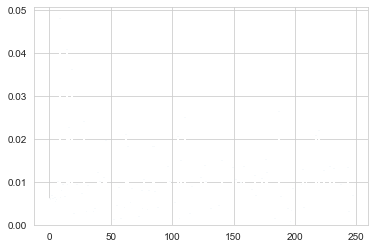

In [63]:
bold("**xgboost特征重要性**")
# from xgboost import feature_importances_
    
from matplotlib import pyplot
print(xgb_model.feature_importances_)
pyplot.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
feature_important = dict(zip(feature_name, xgb_model.feature_importances_))
# print("xgboost特征重要性:", feature_important)
# feature_import_usefull = [key for key, value in feature_important.items() if value >0.0]
# print("\n\nxgboost 重要性 > 0 特征类别：", len(feature_import_usefull),  feature_import_usefull)

feature_important=sorted(feature_important.items(), key=lambda x: x[1], reverse=True)
print("xgboost特征重要性:", feature_important)

feature_import_usefull = [key for (key, value) in feature_important if value >0.0]

print("\n\n xgboost特征 重要性 > 0 特征类别：", len(feature_import_usefull),  feature_import_usefull)

In [45]:

# lightgbm 
feature_name = columns
fi = []
cv_score = []
test_pred = np.zeros((test.shape[0],))
skf = StratifiedKFold(n_splits=5, random_state=2019, shuffle=True)
lgb_paras = {'objective': 'binary',
             'learning_rate': 0.1,
             'max_depth': 3 ,
             'feature_fraction': 0.8, 
             'bagging_fraction' : 0.8,
             'num_threads':-1}

for index, (train_index, test_index) in enumerate(skf.split(train, train_label['Label'])):
    print(index)
    train_x, test_x, train_y, test_y = train.iloc[train_index],train.iloc[test_index], train_label['Label'].iloc[train_index], train_label['Label'].iloc[test_index]
    lgb_model = lgb.train(lgb_paras,
                          train_set = lgb.Dataset(train_x[feature_name], train_y),
                          valid_sets=[lgb.Dataset(train_x[feature_name], train_y), lgb.Dataset(test_x[feature_name],test_y)],
                          num_boost_round=400 ,
                          verbose_eval=50,
#                           early_stopping_rounds=30,
#                           feval=roc_auc_score
                          )
    y_val = lgb_model.predict(test_x[feature_name], num_iteration=lgb_model.best_iteration)
    print( "test roc_auc",  roc_auc_score(test_y , y_val) )
    cv_score.append(roc_auc_score(test_y,y_val))
    print("cv_score:", cv_score[index])
    test_pred += lgb_model.predict(test[feature_name], num_iteration=lgb_model.best_iteration) / 5
print(cv_score)
test_pred = [0.0 if r < 0  else r for r in test_pred]
test_pred = [1.0 if r > 1.0  else r for r in test_pred]
submission = pd.read_csv('../data/submission.csv')
submission['Label'] = test_pred
submission.to_csv('../result/lgb_dan_1207.csv',index=False)

0
[50]	valid_0's binary_logloss: 0.130794	valid_1's binary_logloss: 0.14428
[100]	valid_0's binary_logloss: 0.122905	valid_1's binary_logloss: 0.144008
[150]	valid_0's binary_logloss: 0.116586	valid_1's binary_logloss: 0.144593
[200]	valid_0's binary_logloss: 0.110267	valid_1's binary_logloss: 0.147335
[250]	valid_0's binary_logloss: 0.104971	valid_1's binary_logloss: 0.148988
[300]	valid_0's binary_logloss: 0.100785	valid_1's binary_logloss: 0.15085
[350]	valid_0's binary_logloss: 0.096971	valid_1's binary_logloss: 0.152288
[400]	valid_0's binary_logloss: 0.0935772	valid_1's binary_logloss: 0.153656
test roc_auc 0.9179027125023399
cv_score: 0.9179027125023399
1
[50]	valid_0's binary_logloss: 0.130862	valid_1's binary_logloss: 0.145111
[100]	valid_0's binary_logloss: 0.123726	valid_1's binary_logloss: 0.144653
[150]	valid_0's binary_logloss: 0.117586	valid_1's binary_logloss: 0.145714
[200]	valid_0's binary_logloss: 0.111379	valid_1's binary_logloss: 0.146901
[250]	valid_0's binary_log

**lightgbm特征重要性**

[ 61  36  11 156 110  19  41 212 237 274 149 142   0   0   1   2   5   0
   2   4   6   0   9   0   0   4   5   0  13   0   9  17   0   0   0   0
   0   2   0  13   0  12   0   0   2   3   8   0   0   0   0   0   6   0
   1   4   3   0   5   0   0   7   3   0  10   0  19   2   0   0   0   0
   5   9   0  13   0  14   0   0   4  11   6   0  40   7   3   0   1   1
   0   0   0   0   0   0   3   0   1   0   0   0   0   0   1   0   0  18
   0   2  30   0   0   0   4   0  10   0   0   0   0   0   0   5   1   0
  42  16   0   0   1   1   0   0   0   0   0   0   5   0   6   0   0   0
   0   0   3   0   0   2   0   4  17   0   0   0   1   0  17   0   0   0
   0   0   1   9   1  10 238   0   0   0   0  13   0   7   6   7   0   6
   0   0   3   4   0   0   0  11  10   0   0   0   0   2   4   0   8   0
   7   0   0   4   0   0   0  23   5  15   2   3   0   0   0   0   0   0
   0  17   0   4   0   0   0  10   0   0   0   0   8   0  12   3   0   0
   0   0   0  25   0   0   0   0   0   3  13   6   

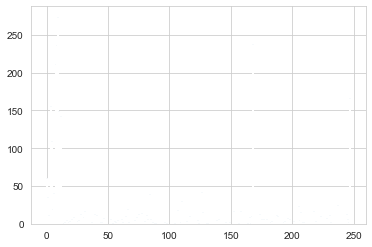

NameError: name 'feature_name_uesd' is not defined

In [68]:

bold("**lightgbm特征重要性**")
# from lightgbm import feature_importances_ 
print(lgb_model.feature_importance())
pyplot.bar(range(len(lgb_model.feature_importance())), lgb_model.feature_importance())
plt.show()
feature_important = dict(zip(feature_name_uesd, lgb_model.feature_importance()))
# print("lightgbm特征重要性:", feature_important)
# feature_import_usefull = [key for key, value in feature_important.items() if value >0.0]
# print("\n\nlightgbm 重要性 > 0 特征类别：", len(feature_import_usefull),  feature_import_usefull)


feature_important=sorted(feature_important.items(), key=lambda x: x[1], reverse=True)
print("lgb_model特征重要性:", feature_important)

feature_import_usefull = [key for (key, value) in feature_important if value >0.0]

print("\n\n lgb_model特征 重要性 > 0 特征类别：", len(feature_import_usefull),  feature_import_usefull)

In [ ]:
# 上述catboost单模型 0.9247
三模型blending：0.9252

# 训练2
上述使用了原始特征，加上年末-年初特征

并按照缺失值<60来计算


In [49]:
train.columns[np.where(train.isnull().sum()/train.shape[0] < 0.5)[0]]

Index(['企业类型', '登记机关', '企业状态', '注册资本', '行业门类', '企业类别', '管辖机关', '增值税', '企业所得税',
       '印花税', '教育费', '城建税', '经营范围2', '企业所得税与增值税之比'],
      dtype='object')

In [50]:
train['企业所得税与印花税之比'] = train['企业所得税']/ train['印花税']
test['企业所得税与印花税之比'] = test['企业所得税']/test['印花税']
train['企业所得税与教育费之比'] = train['企业所得税']/ train['教育费']
test['企业所得税与教育费之比'] = test['企业所得税']/test['教育费']

train['企业所得税与印花税之比'] = train['企业所得税']/ train['印花税']
test['企业所得税与印花税之比'] = test['企业所得税']/test['印花税']
train['企业所得税与城建税之比'] = train['企业所得税']/ train['城建税']
test['企业所得税与城建税之比'] = test['企业所得税']/test['城建税']

In [53]:
train.columns[np.where(train.isnull().sum()/train.shape[0] < 0.6)[0]]

Index(['企业类型', '登记机关', '企业状态', '注册资本', '行业门类', '企业类别', '管辖机关', '增值税', '企业所得税',
       '印花税',
       ...
       '应收股利', '应收利息', '应收票据', '预付款项', '资产总计', '在建工程', '企业所得税与增值税之比',
       '企业所得税与印花税之比', '企业所得税与教育费之比', '企业所得税与城建税之比'],
      dtype='object', length=251)

In [52]:
feature_name =['企业类型', '登记机关', '企业状态', '注册资本', '行业门类', '企业类别', '管辖机关', '增值税', '企业所得税',
       '印花税', '教育费', '城建税', '经营范围2', '企业所得税与增值税之比', '企业所得税与印花税之比',
       '企业所得税与教育费之比', '企业所得税与城建税之比'] 
#特征选择  使用第1步分
# feature_name  =  ['企业类型', '登记机关', '企业状态', '注册资本', '行业门类', '企业类别', '管辖机关', '增值税', '企业所得税', '印花税', '教育费', '城建税', '递延收益_年初数', '长期借款_年初数', '长期应付款_年初数', '短期借款_年初数', '递延所得税负债_年初数', '非流动负债合计_年初数', '负债合计_年初数', '负债和所有者权益总计_年初数', '交易性金融负债_年初数', '流动负债合计_年初数', '其他非流动负债_年初数', '其他流动负债_年初数', '其他应付款_年初数', '实收资本（股本）_年初数', '实收资本（或股本）净额_年初数', '所有者权益合计_年初数', '未分配利润_年初数', '应付票据_年初数', '应付职工薪酬_年初数', '应付债券_年初数', '应付账款_年初数', '预计负债_年初数', '应交税费_年初数', '一年内到期的非流动负债_年初数', '预收款项_年初数', '盈余公积_年初数', '资本公积_年初数', '长期借款_年末数', '长期应付款_年末数', '递延所得税负债_年末数', '非流动负债合计_年末数', '负债合计_年末数', '负债和所有者权益总计_年末数', '流动负债合计_年末数', '其他非流动负债_年末数', '其他流动负债_年末数', '其他应付款_年末数', '实收资本（股本）_年末数', '小企业_应付利润_年末数', '应付股利_年末数', '应付票据_年末数', '应付职工薪酬_年末数', '应付债券_年末数', '应付账款_年末数', '预计负债_年末数', '应交税费_年末数', '一年内到期的非流动负债_年末数', '预收款项_年末数', '盈余公积_年末数', '资本公积_年末数', '专项应付款_年末数', '货币资金_年初数', '存货_年初数', '存货中的原材料_年初数', '长期待摊费用_年初数', '长期应收款_年初数', '短期投资_年初数', '待摊费用_年初数', '工程物资_年初数', '固定资产合计_年初数', '固定资产净值_年初数', '固定资产原价_年初数', '交易性金融资产_年初数', '库存商品(产成品)_年初数', '开发支出_年初数', '可供出售金融资产_年初数', '流动资产合计_年初数', '其他流动资产_年初数', '其他应收款_年初数', '生产性生物资产_年初数', '商誉_年初数', '无形资产_年初数', '应收账款_年初数', '应收股利_年初数', '应收票据_年初数', '预付款项_年初数', '资产总计_年初数', '货币资金_年末数', '存货_年末数', '存货中的原材料_年末数', '存货中的周转材料_年末数', '长期待摊费用_年末数', '长期股权投资_年末数', '长期应收款_年末数', '持有至到期投资_年末数', '递延所得税资产_年末数', '非流动资产合计_年末数', '工程物资_年末数', '固定资产合计_年末数', '固定资产清理_年末数', '固定资产原价_年末数', '交易性金融资产_年末数', '库存商品(产成品)_年末数', '开发支出_年末数', '可供出售金融资产_年末数', '流动资产合计_年末数', '其他非流动资产_年末数', '其他应收款_年末数', '生产性生物资产_年末数', '投资性房地产_年末数', '无形资产_年末数', '油气资产_年末数', '应收股利_年末数', '应收利息_年末数', '应收票据_年末数', '预付款项_年末数', '资产总计_年末数', '经营范围2', '递延收益', '长期负债合计', '长期应付款', '递延所得税负债', '负债合计', '交易性金融负债', '流动负债合计', '其他非流动负债', '其他流动负债', '其他应付款', '所有者权益合计', '未分配利润', '应付福利费', '应付股利', '应付职工薪酬', '应付账款', '预计负债', '应交税费', '一年内到期的非流动负债', '盈余公积', '资本公积', '货币资金', '存货', '存货中的原材料', '存货中的周转材料', '长期待摊费用', '持有至到期投资', '短期投资', '递延所得税资产', '非流动资产合计', '工程物资', '固定资产合计', '固定资产清理', '开发支出', '流动资产合计', '其他非流动资产', '其他流动资产', '其他应收款', '生产性生物资产', '无形资产', '应收账款', '一年内到期的非流动资产', '应收股利', '预付款项', '在建工程', '企业所得税与增值税之比']



fi = []
cv_score = []
test_pred = np.zeros((test.shape[0],))
skf = StratifiedKFold(n_splits=5, random_state=2019, shuffle=True)

for index, (train_index, test_index) in enumerate(skf.split(train, train_label['Label'])):
    print(index)
    train_x, test_x, train_y, test_y = train.iloc[train_index],train.iloc[test_index], train_label['Label'].iloc[train_index], train_label['Label'].iloc[test_index]
    cat_model = CatBoostRegressor(iterations=300,
                              depth=5,
                              learning_rate=0.1, 
                              loss_function='RMSE', 
                              verbose=20, 
#                               early_stopping_rounds=20
                             )
    cat_model.fit(train_x[feature_name], train_y, 
             eval_set=(test_x[feature_name], test_y))
    y_val = cat_model.predict(test_x[feature_name])
    print("roc_auc:", roc_auc_score(test_y, y_val))
    cv_score.append(roc_auc_score(test_y,y_val))
    print("cv_score:", cv_score[index])
    test_pred += cat_model.predict(test[feature_name]) / 5
print(cv_score)
test_pred = [0.0 if r < 0  else r for r in test_pred]
test_pred = [1.0 if r > 1.0  else r for r in test_pred]
submission = pd.read_csv('../data/submission.csv')
submission['Label'] = test_pred
submission.to_csv('../result/catb_dan_1207-01.csv',index=False)


0
0:	learn: 0.2412068	test: 0.2418982	best: 0.2418982 (0)	total: 5.65ms	remaining: 1.69s
20:	learn: 0.2117750	test: 0.2137838	best: 0.2137838 (20)	total: 102ms	remaining: 1.35s
40:	learn: 0.2082950	test: 0.2131336	best: 0.2130164 (32)	total: 195ms	remaining: 1.23s
60:	learn: 0.2061358	test: 0.2131488	best: 0.2128495 (50)	total: 289ms	remaining: 1.13s
80:	learn: 0.2040674	test: 0.2134979	best: 0.2128495 (50)	total: 383ms	remaining: 1.03s
100:	learn: 0.2019624	test: 0.2134664	best: 0.2128495 (50)	total: 481ms	remaining: 947ms
120:	learn: 0.2001473	test: 0.2130958	best: 0.2128495 (50)	total: 579ms	remaining: 856ms
140:	learn: 0.1981784	test: 0.2132922	best: 0.2128495 (50)	total: 672ms	remaining: 758ms
160:	learn: 0.1962050	test: 0.2134340	best: 0.2128495 (50)	total: 765ms	remaining: 661ms
180:	learn: 0.1944583	test: 0.2138861	best: 0.2128495 (50)	total: 860ms	remaining: 565ms
200:	learn: 0.1927217	test: 0.2142353	best: 0.2128495 (50)	total: 961ms	remaining: 473ms
220:	learn: 0.1910592	tes

In [54]:
train.columns[np.where(train.isnull().sum()/train.shape[0] < 0.6)[0]].values

array(['企业类型', '登记机关', '企业状态', '注册资本', '行业门类', '企业类别', '管辖机关', '增值税',
       '企业所得税', '印花税', '教育费', '城建税', '递延收益_年初数', '长期负债合计_年初数', '长期借款_年初数',
       '长期应付款_年初数', '短期借款_年初数', '递延所得税负债_年初数', '非流动负债合计_年初数', '负债合计_年初数',
       '负债和所有者权益总计_年初数', '交易性金融负债_年初数', '流动负债合计_年初数', '其他非流动负债_年初数',
       '其他负债（或长期负债）_年初数', '其他流动负债_年初数', '其他应付款_年初数', '其他应交款_年初数',
       '实收资本（股本）_年初数', '实收资本（或股本）净额_年初数', '所有者权益合计_年初数', '未分配利润_年初数',
       '小企业_应付利润_年初数', '应付福利费_年初数', '应付股利_年初数', '应付利息_年初数', '应付票据_年初数',
       '应付职工薪酬_年初数', '应付债券_年初数', '应付账款_年初数', '预计负债_年初数', '应交税费_年初数',
       '一年内到期的非流动负债_年初数', '预提费用_年初数', '预收款项_年初数', '盈余公积_年初数', '资本公积_年初数',
       '专项应付款_年初数', '递延收益_年末数', '长期负债合计_年末数', '长期借款_年末数', '长期应付款_年末数',
       '短期借款_年末数', '递延所得税负债_年末数', '非流动负债合计_年末数', '负债合计_年末数',
       '负债和所有者权益总计_年末数', '交易性金融负债_年末数', '流动负债合计_年末数', '其他非流动负债_年末数',
       '其他负债（或长期负债）_年末数', '其他流动负债_年末数', '其他应付款_年末数', '其他应交款_年末数',
       '实收资本（股本）_年末数', '实收资本（或股本）净额_年末数', '所有者权益合计_年末数', '未分配利润_年末数',
       '小企业_应付利润_年末数', '

In [ ]:
columns=['企业类型', '登记机关', '企业状态', '注册资本', '行业门类', '企业类别', '管辖机关', '增值税',
       '企业所得税', '印花税', '教育费', '城建税', '递延收益_年初数', '长期负债合计_年初数', '长期借款_年初数',
       '长期应付款_年初数', '短期借款_年初数', '递延所得税负债_年初数', '非流动负债合计_年初数', '负债合计_年初数',
       '负债和所有者权益总计_年初数', '交易性金融负债_年初数', '流动负债合计_年初数', '其他非流动负债_年初数',
       '其他负债（或长期负债）_年初数', '其他流动负债_年初数', '其他应付款_年初数', '其他应交款_年初数',
       '实收资本（股本）_年初数', '实收资本（或股本）净额_年初数', '所有者权益合计_年初数', '未分配利润_年初数',
       '小企业_应付利润_年初数', '应付福利费_年初数', '应付股利_年初数', '应付利息_年初数', '应付票据_年初数',
       '应付职工薪酬_年初数', '应付债券_年初数', '应付账款_年初数', '预计负债_年初数', '应交税费_年初数',
       '一年内到期的非流动负债_年初数', '预提费用_年初数', '预收款项_年初数', '盈余公积_年初数', '资本公积_年初数',
       '专项应付款_年初数', '递延收益_年末数', '长期负债合计_年末数', '长期借款_年末数', '长期应付款_年末数',
       '短期借款_年末数', '递延所得税负债_年末数', '非流动负债合计_年末数', '负债合计_年末数',
       '负债和所有者权益总计_年末数', '交易性金融负债_年末数', '流动负债合计_年末数', '其他非流动负债_年末数',
       '其他负债（或长期负债）_年末数', '其他流动负债_年末数', '其他应付款_年末数', '其他应交款_年末数',
       '实收资本（股本）_年末数', '实收资本（或股本）净额_年末数', '所有者权益合计_年末数', '未分配利润_年末数',
       '小企业_应付利润_年末数', '应付福利费_年末数', '应付股利_年末数', '应付利息_年末数', '应付票据_年末数',
       '应付职工薪酬_年末数', '应付债券_年末数', '应付账款_年末数', '预计负债_年末数', '应交税费_年末数',
       '一年内到期的非流动负债_年末数', '预提费用_年末数', '预收款项_年末数', '盈余公积_年末数', '资本公积_年末数',
       '专项应付款_年末数', '货币资金_年初数', '存货_年初数', '存货中的原材料_年初数', '存货中的周转材料_年初数',
       '长期待摊费用_年初数', '长期股权投资_年初数', '长期投资合计_年初数', '长期应收款_年初数',
       '持有至到期投资_年初数', '短期投资_年初数', '待摊费用_年初数', '递延所得税资产_年初数',
       '非流动资产合计_年初数', '工程物资_年初数', '固定资产合计_年初数', '固定资产净额_年初数',
       '固定资产净值_年初数', '固定资产清理_年初数', '固定资产原价_年初数', '交易性金融资产_年初数',
       '库存商品(产成品)_年初数', '开发支出_年初数', '可供出售金融资产_年初数', '流动资产合计_年初数',
       '其他非流动资产_年初数', '其他流动资产_年初数', '其他应收款_年初数', '生产性生物资产_年初数', '商誉_年初数',
       '投资性房地产_年初数', '无形资产_年初数', '无形资产及其他资产合计_年初数', '应收账款_年初数',
       '一年内到期的非流动资产_年初数', '油气资产_年初数', '应收补贴款_年初数', '应收股利_年初数', '应收利息_年初数',
       '应收票据_年初数', '预付款项_年初数', '资产总计_年初数', '在建工程_年初数', '货币资金_年末数',
       '存货_年末数', '存货中的原材料_年末数', '存货中的周转材料_年末数', '长期待摊费用_年末数',
       '长期股权投资_年末数', '长期投资合计_年末数', '长期应收款_年末数', '持有至到期投资_年末数', '短期投资_年末数',
       '待摊费用_年末数', '递延所得税资产_年末数', '非流动资产合计_年末数', '工程物资_年末数', '固定资产合计_年末数',
       '固定资产净额_年末数', '固定资产净值_年末数', '固定资产清理_年末数', '固定资产原价_年末数',
       '交易性金融资产_年末数', '库存商品(产成品)_年末数', '开发支出_年末数', '可供出售金融资产_年末数',
       '流动资产合计_年末数', '其他非流动资产_年末数', '其他流动资产_年末数', '其他应收款_年末数',
       '生产性生物资产_年末数', '商誉_年末数', '投资性房地产_年末数', '无形资产_年末数',
       '无形资产及其他资产合计_年末数', '应收账款_年末数', '一年内到期的非流动资产_年末数', '油气资产_年末数',
       '应收补贴款_年末数', '应收股利_年末数', '应收利息_年末数', '应收票据_年末数', '预付款项_年末数',
       '资产总计_年末数', '在建工程_年末数', '经营范围2', '递延收益', '长期负债合计', '长期借款', '长期应付款',
       '短期借款', '递延所得税负债', '非流动负债合计', '负债合计', '负债和所有者权益总计', '交易性金融负债',
       '流动负债合计', '其他非流动负债', '其他负债（或长期负债）', '其他流动负债', '其他应付款', '其他应交款',
       '实收资本（股本）', '实收资本（或股本）净额', '所有者权益合计', '未分配利润', '小企业_应付利润', '应付福利费',
       '应付股利', '应付利息', '应付票据', '应付职工薪酬', '应付债券', '应付账款', '预计负债', '应交税费',
       '一年内到期的非流动负债', '预提费用', '预收款项', '盈余公积', '资本公积', '专项应付款', '货币资金',
       '存货', '存货中的原材料', '存货中的周转材料', '长期待摊费用', '长期股权投资', '长期投资合计', '长期应收款',
       '持有至到期投资', '短期投资', '待摊费用', '递延所得税资产', '非流动资产合计', '工程物资', '固定资产合计',
       '固定资产净额', '固定资产净值', '固定资产清理', '固定资产原价', '交易性金融资产', '库存商品(产成品)',
       '开发支出', '可供出售金融资产', '流动资产合计', '其他非流动资产', '其他流动资产', '其他应收款',
       '生产性生物资产', '商誉', '投资性房地产', '无形资产', '无形资产及其他资产合计', '应收账款',
       '一年内到期的非流动资产', '油气资产', '应收补贴款', '应收股利', '应收利息', '应收票据', '预付款项',
       '资产总计', '在建工程', '企业所得税与增值税之比', '企业所得税与印花税之比', '企业所得税与教育费之比',
       '企业所得税与城建税之比'

In [55]:
feature_name = columns 

fi = []
cv_score = []
test_pred = np.zeros((test.shape[0],))
skf = StratifiedKFold(n_splits=5, random_state=2019, shuffle=True)

for index, (train_index, test_index) in enumerate(skf.split(train, train_label['Label'])):
    print(index)
    train_x, test_x, train_y, test_y = train.iloc[train_index],train.iloc[test_index], train_label['Label'].iloc[train_index], train_label['Label'].iloc[test_index]
    cat_model = CatBoostRegressor(iterations=300,
                              depth=5,
                              learning_rate=0.1, 
                              loss_function='RMSE', 
                              verbose=20, 
#                               early_stopping_rounds=20
                             )
    cat_model.fit(train_x[feature_name], train_y, 
             eval_set=(test_x[feature_name], test_y))
    y_val = cat_model.predict(test_x[feature_name])
    print("roc_auc:", roc_auc_score(test_y, y_val))
    cv_score.append(roc_auc_score(test_y,y_val))
    print("cv_score:", cv_score[index])
    test_pred += cat_model.predict(test[feature_name]) / 5
print(cv_score)
test_pred = [0.0 if r < 0  else r for r in test_pred]
test_pred = [1.0 if r > 1.0  else r for r in test_pred]
submission = pd.read_csv('../data/submission.csv')
submission['Label'] = test_pred
submission.to_csv('../result/catb_dan_1207-01.csv',index=False)


0
0:	learn: 0.2419834	test: 0.2427520	best: 0.2427520 (0)	total: 15.8ms	remaining: 4.73s
20:	learn: 0.2123956	test: 0.2138617	best: 0.2138617 (20)	total: 242ms	remaining: 3.21s
40:	learn: 0.2107507	test: 0.2127941	best: 0.2127934 (39)	total: 463ms	remaining: 2.93s
60:	learn: 0.2100046	test: 0.2124036	best: 0.2124036 (60)	total: 696ms	remaining: 2.73s
80:	learn: 0.2096649	test: 0.2123857	best: 0.2123632 (64)	total: 929ms	remaining: 2.51s
100:	learn: 0.2077429	test: 0.2123778	best: 0.2123632 (64)	total: 1.18s	remaining: 2.33s
120:	learn: 0.2057585	test: 0.2127478	best: 0.2123216 (107)	total: 1.42s	remaining: 2.1s
140:	learn: 0.2039491	test: 0.2127405	best: 0.2123216 (107)	total: 1.67s	remaining: 1.88s
160:	learn: 0.2026401	test: 0.2128675	best: 0.2123216 (107)	total: 1.93s	remaining: 1.66s
180:	learn: 0.2010285	test: 0.2133171	best: 0.2123216 (107)	total: 2.18s	remaining: 1.43s
200:	learn: 0.2000259	test: 0.2132841	best: 0.2123216 (107)	total: 2.44s	remaining: 1.2s
220:	learn: 0.1984572	

In [56]:
## xgboost 单模型
feature_name = columns

object_col = ['企业类型', '登记机关','企业状态', '行业门类', '企业类别', '管辖机关']
for i in tqdm(object_col):
    lbl = LabelEncoder()
    train[i] = lbl.fit_transform(train[i].astype(str))

fi = []
cv_score = []
test_pred = np.zeros((test.shape[0],))
skf = StratifiedKFold(n_splits=5, random_state=2019, shuffle=True)


for index, (train_index, test_index) in enumerate(skf.split(train, train_label['Label'])):
    print(index)
    train_x, test_x, train_y, test_y = train.iloc[train_index],train.iloc[test_index], train_label['Label'].iloc[train_index], train_label['Label'].iloc[test_index]
    xgb_model = XGBRegressor(learning_rate=0.15,
                              n_estimators=400,
                              max_depth=5,
                              gamma=0,
                              verbosity=1,
                              subsample=0.8,
                            #   min_child_weight=1, 
                              objective='binary:logistic')
    eval_set = [(train_x[feature_name], train_y), (test_x[feature_name], test_y)]
    xgb_model.fit(train_x[feature_name], train_y, 
#         early_stopping_rounds = 20,
        eval_metric=["error", "logloss",'auc'], 
        eval_set=eval_set, verbose=50)
    
   
    y_val = xgb_model.predict(test_x[feature_name])
    print("roc_auc:", roc_auc_score(test_y, y_val))
    cv_score.append(roc_auc_score(test_y, y_val))
    print("cv_score:", cv_score[index])
    test_pred += xgb_model.predict(test[feature_name]) / 5
print(cv_score)
test_pred = [0.0 if r < 0  else r for r in test_pred]
test_pred = [1.0 if r > 1.0  else r for r in test_pred]
submission = pd.read_csv('../data/submission.csv')
submission['Label'] = test_pred
submission.to_csv('../result/xgb_dan_1207-01.csv',index=False)

100%|██████████| 6/6 [00:00<00:00, 86.93it/s]


0


C:\Users\bai\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	validation_0-error:0.066742	validation_0-logloss:0.578697	validation_0-auc:0.912663	validation_1-error:0.074113	validation_1-logloss:0.579834	validation_1-auc:0.889386
[20]	validation_0-error:0.060738	validation_0-logloss:0.138423	validation_0-auc:0.949902	validation_1-error:0.066458	validation_1-logloss:0.155985	validation_1-auc:0.914338
[40]	validation_0-error:0.058911	validation_0-logloss:0.117305	validation_0-auc:0.964091	validation_1-error:0.066806	validation_1-logloss:0.144561	validation_1-auc:0.925884
[60]	validation_0-error:0.052558	validation_0-logloss:0.107883	validation_0-auc:0.973038	validation_1-error:0.067502	validation_1-logloss:0.146572	validation_1-auc:0.923941
[80]	validation_0-error:0.04551	validation_0-logloss:0.098457	validation_0-auc:0.980296	validation_1-error:0.066806	validation_1-logloss:0.148634	validation_1-auc:0.921711
[100]	validation_0-error:0.039941	validation_0-logloss:0.09069	validation_0-auc:0.984864	validation_1-error:0.069589	validation_1-logloss

C:\Users\bai\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	validation_0-error:0.064561	validation_0-logloss:0.5787	validation_0-auc:0.912837	validation_1-error:0.068569	validation_1-logloss:0.579533	validation_1-auc:0.900549
[20]	validation_0-error:0.061864	validation_0-logloss:0.139108	validation_0-auc:0.949074	validation_1-error:0.065437	validation_1-logloss:0.152345	validation_1-auc:0.920084
[40]	validation_0-error:0.06082	validation_0-logloss:0.119431	validation_0-auc:0.961713	validation_1-error:0.064741	validation_1-logloss:0.142794	validation_1-auc:0.919765
[60]	validation_0-error:0.052989	validation_0-logloss:0.10878	validation_0-auc:0.973146	validation_1-error:0.066481	validation_1-logloss:0.144241	validation_1-auc:0.918073
[80]	validation_0-error:0.048203	validation_0-logloss:0.10076	validation_0-auc:0.979237	validation_1-error:0.067873	validation_1-logloss:0.146167	validation_1-auc:0.916764
[100]	validation_0-error:0.038893	validation_0-logloss:0.092219	validation_0-auc:0.984571	validation_1-error:0.07031	validation_1-logloss:0.1

C:\Users\bai\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	validation_0-error:0.0643	validation_0-logloss:0.578356	validation_0-auc:0.914092	validation_1-error:0.068221	validation_1-logloss:0.580149	validation_1-auc:0.903497
[20]	validation_0-error:0.060559	validation_0-logloss:0.137306	validation_0-auc:0.952124	validation_1-error:0.066481	validation_1-logloss:0.155618	validation_1-auc:0.91457
[40]	validation_0-error:0.057252	validation_0-logloss:0.116557	validation_0-auc:0.965323	validation_1-error:0.067525	validation_1-logloss:0.145885	validation_1-auc:0.913047
[60]	validation_0-error:0.049943	validation_0-logloss:0.106542	validation_0-auc:0.974312	validation_1-error:0.069962	validation_1-logloss:0.148484	validation_1-auc:0.9118
[80]	validation_0-error:0.040981	validation_0-logloss:0.096491	validation_0-auc:0.981191	validation_1-error:0.070658	validation_1-logloss:0.151464	validation_1-auc:0.91129
[100]	validation_0-error:0.036631	validation_0-logloss:0.088723	validation_0-auc:0.985994	validation_1-error:0.07031	validation_1-logloss:0.15

C:\Users\bai\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	validation_0-error:0.064648	validation_0-logloss:0.578807	validation_0-auc:0.907193	validation_1-error:0.065785	validation_1-logloss:0.579011	validation_1-auc:0.904925
[20]	validation_0-error:0.062299	validation_0-logloss:0.140249	validation_0-auc:0.945585	validation_1-error:0.066481	validation_1-logloss:0.149633	validation_1-auc:0.917295
[40]	validation_0-error:0.058818	validation_0-logloss:0.120048	validation_0-auc:0.960202	validation_1-error:0.066481	validation_1-logloss:0.137769	validation_1-auc:0.925407
[60]	validation_0-error:0.05238	validation_0-logloss:0.110069	validation_0-auc:0.971225	validation_1-error:0.067177	validation_1-logloss:0.13816	validation_1-auc:0.925177
[80]	validation_0-error:0.046202	validation_0-logloss:0.099866	validation_0-auc:0.979349	validation_1-error:0.067525	validation_1-logloss:0.140487	validation_1-auc:0.925197
[100]	validation_0-error:0.040198	validation_0-logloss:0.092383	validation_0-auc:0.98451	validation_1-error:0.068569	validation_1-logloss:

C:\Users\bai\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	validation_0-error:0.064039	validation_0-logloss:0.578682	validation_0-auc:0.913507	validation_1-error:0.067177	validation_1-logloss:0.579807	validation_1-auc:0.893585
[20]	validation_0-error:0.062125	validation_0-logloss:0.138605	validation_0-auc:0.948841	validation_1-error:0.065437	validation_1-logloss:0.15199	validation_1-auc:0.907818
[40]	validation_0-error:0.058905	validation_0-logloss:0.116863	validation_0-auc:0.963801	validation_1-error:0.065437	validation_1-logloss:0.142784	validation_1-auc:0.916523
[60]	validation_0-error:0.053946	validation_0-logloss:0.108567	validation_0-auc:0.972797	validation_1-error:0.064741	validation_1-logloss:0.142478	validation_1-auc:0.920777
[80]	validation_0-error:0.043244	validation_0-logloss:0.098286	validation_0-auc:0.981325	validation_1-error:0.067525	validation_1-logloss:0.143003	validation_1-auc:0.921337
[100]	validation_0-error:0.038806	validation_0-logloss:0.091198	validation_0-auc:0.985244	validation_1-error:0.071354	validation_1-loglos

In [57]:

# lightgbm 
feature_name = columns
fi = []
cv_score = []
test_pred = np.zeros((test.shape[0],))
skf = StratifiedKFold(n_splits=5, random_state=2019, shuffle=True)
lgb_paras = {'objective': 'binary',
             'learning_rate': 0.1,
             'max_depth': 3 ,
             'feature_fraction': 0.8, 
             'bagging_fraction' : 0.8,
             'num_threads':-1}

for index, (train_index, test_index) in enumerate(skf.split(train, train_label['Label'])):
    print(index)
    train_x, test_x, train_y, test_y = train.iloc[train_index],train.iloc[test_index], train_label['Label'].iloc[train_index], train_label['Label'].iloc[test_index]
    lgb_model = lgb.train(lgb_paras,
                          train_set = lgb.Dataset(train_x[feature_name], train_y),
                          valid_sets=[lgb.Dataset(train_x[feature_name], train_y), lgb.Dataset(test_x[feature_name],test_y)],
                          num_boost_round=400 ,
                          verbose_eval=50,
#                           early_stopping_rounds=30,
#                           feval=roc_auc_score
                          )
    y_val = lgb_model.predict(test_x[feature_name], num_iteration=lgb_model.best_iteration)
    print( "test roc_auc",  roc_auc_score(test_y , y_val) )
    cv_score.append(roc_auc_score(test_y,y_val))
    print("cv_score:", cv_score[index])
    test_pred += lgb_model.predict(test[feature_name], num_iteration=lgb_model.best_iteration) / 5
print(cv_score)
test_pred = [0.0 if r < 0  else r for r in test_pred]
test_pred = [1.0 if r > 1.0  else r for r in test_pred]
submission = pd.read_csv('../data/submission.csv')
submission['Label'] = test_pred
submission.to_csv('../result/lgb_dan_1207-01.csv',index=False)

0
[50]	valid_0's binary_logloss: 0.130473	valid_1's binary_logloss: 0.143917
[100]	valid_0's binary_logloss: 0.122326	valid_1's binary_logloss: 0.143781
[150]	valid_0's binary_logloss: 0.116411	valid_1's binary_logloss: 0.144781
[200]	valid_0's binary_logloss: 0.110164	valid_1's binary_logloss: 0.146547
[250]	valid_0's binary_logloss: 0.106051	valid_1's binary_logloss: 0.147564
[300]	valid_0's binary_logloss: 0.10186	valid_1's binary_logloss: 0.149064
[350]	valid_0's binary_logloss: 0.0978496	valid_1's binary_logloss: 0.150569
[400]	valid_0's binary_logloss: 0.0942874	valid_1's binary_logloss: 0.152121
test roc_auc 0.9201324229257191
cv_score: 0.9201324229257191
1
[50]	valid_0's binary_logloss: 0.131133	valid_1's binary_logloss: 0.145225
[100]	valid_0's binary_logloss: 0.123685	valid_1's binary_logloss: 0.143906
[150]	valid_0's binary_logloss: 0.11792	valid_1's binary_logloss: 0.144253
[200]	valid_0's binary_logloss: 0.112138	valid_1's binary_logloss: 0.145573
[250]	valid_0's binary_lo